# India ML Hiring Hackathon, Analytics Vidhya.

Problem Statement
Loan Delinquency Prediction
Loan default prediction is one of the most critical and crucial problem faced by financial institutions and organizations as it has a noteworthy effect on the profitability of these institutions. In recent years, there is a tremendous increase in the volume of non – performing loans which results in a jeopardizing effect on the growth of these institutions.
 

Therefore, to maintain a healthy portfolio, the banks put stringent monitoring and evaluation measures in place to ensure timely repayment of loans by borrowers. Despite these measures, a major proportion of loans become delinquent. Delinquency occurs when a borrower misses a payment against his/her loan.

 

Given the information like mortgage details, borrowers related details and payment details, our objective is to identify the delinquency status of loans for the next month given the delinquency status for the previous 12 months (in number of months).

In [16]:
## India ML Hiring Hackathon!
# pyforest-lazy is an opensource library that imports all popular #Python Data Science libraries
from pyforest import *
import pandas_profiling

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

train_ = pd.read_csv('/home/aakash/Downloads/India_AV/train.csv')
test_ = pd.read_csv('/home/aakash/Downloads/India_AV/test.csv')
print(train_.shape) ## 29 data columns. 116058 data points.
print(test_.shape) # 35866 data points,
train_.head()

(116058, 29)
(35866, 28)


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [ ]:
train_.profile_report()

In [ ]:
test_.profile_report()

In [17]:
## Concatenating the datasets so that we can do simultaneous preprocessing.
data = pd.concat([train_, test_],  axis = 0, ignore_index = False)

In [18]:
## Numerical and Categorical Columns,
num_col = [x for x in data.dtypes.index if data.dtypes[x] == 'float']
cat_col = [x for x in data.dtypes.index if data.dtypes[x] == 'object']
int_col = [x for x in data.dtypes.index if data.dtypes[x] == 'int64']

In [19]:
data.dtypes

borrower_credit_score       float64
co-borrower_credit_score    float64
debt_to_income_ratio        float64
financial_institution        object
first_payment_date           object
insurance_percent           float64
insurance_type              float64
interest_rate               float64
loan_id                       int64
loan_purpose                 object
loan_term                     int64
loan_to_value                 int64
m1                            int64
m10                           int64
m11                           int64
m12                           int64
m13                         float64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
number_of_borrowers         float64
origination_date             object
source                      

# Insights

So this is a binary classification problem.
m13 -> our target variable.. to predict loan deliquency in the 13th month,

No missing values, in both train and test datasets.
Important Insights-
1). all mi's should be of type boolean and should only have 2 possible values, 0 and 1, so our first task will be to convert all other values(2,3,4..) to 1.

2). number_of_borrowers is highly correlated with co-borrower_credit_score (ρ = 0.9964984777) so we may drop one of them.

3). First Payment Date is a categorical variable. and 02/2012 is the same as Feb-12 and similarly for Mar, Apr, MAy,. 
Note- 
F1 score is our evaluation metric.

In [20]:
## first Payment Date,
data['first_payment_date'][data.first_payment_date == '02/2012'] = 0 
data['first_payment_date'][data.first_payment_date == 'Feb-12'] = 0 
data['first_payment_date'][data.first_payment_date == '03/2012'] = 1
data['first_payment_date'][data.first_payment_date == 'Mar-12'] = 1
data['first_payment_date'][data.first_payment_date == '04/2012'] = 2 
data['first_payment_date'][data.first_payment_date == 'Apr-12'] = 2
data['first_payment_date'][data.first_payment_date == '05/2012'] = 3 
data['first_payment_date'][data.first_payment_date == 'May-12'] = 3
data['first_payment_date'].value_counts()

2    69391
1    62341
3    19524
0      668
Name: first_payment_date, dtype: int64

In [21]:
## Origination Date
data['origination_date'][data.origination_date == '2012-01-01'] = 0 
data['origination_date'][data.origination_date == '01/01/12'] = 0
data['origination_date'][data.origination_date == '2012-02-01'] = 1
data['origination_date'][data.origination_date == '01/02/12'] = 1
data['origination_date'][data.origination_date == '2012-03-01'] = 2 
data['origination_date'][data.origination_date == '01/03/12'] = 2
data['origination_date'].value_counts()

1    68757
0    64144
2    19023
Name: origination_date, dtype: int64

In [22]:
## Categories to Codes,
data['finst'] = data.financial_institution.astype('category').cat.codes   
data['loan_purpose'] = data.loan_purpose.astype('category').cat.codes   
data['source'] = data.source.astype('category').cat.codes   
data['origination_date'] = data.origination_date.astype('category').cat.codes
data['first_payment_date'] = data.first_payment_date.astype('category').cat.codes

In [23]:
## mi's
int_col.remove('loan_id')
int_col.remove('loan_term')
int_col.remove('loan_to_value')
int_col.remove('unpaid_principal_bal')

for col in int_col:
    data[col][data[col] != 0] = 1

In [24]:
train = data[:train_.shape[0]]
test = data[train_.shape[0]:]

y = train['m13'].astype(int)
key1 = test.loan_id
train = train.drop('loan_id' , axis = 1)
test = test.drop('loan_id' , axis = 1)
train = train.drop('m13' , axis = 1)
test = test.drop('m13' , axis = 1)
train = train.drop('financial_institution' , axis = 1)
test = test.drop('financial_institution' , axis = 1)

data = pd.concat([train, test],  axis = 0, ignore_index = False)
print(train.shape); print(test.shape)

(116058, 27)
(35866, 27)


In [25]:
# Using box-cox transformations for normalisation.
from scipy.stats import skew, boxcox
def normalizing(X):
    data[X][data[X] < 0] = 0
    data[X][data[X] > data[X].quantile(0.99)] = data[X].quantile(0.99)
    data[X] = data[X].apply(lambda x: x+np.random.rand())
    data[X] = data[X].apply(lambda x: x+1)
    data[X], _ = boxcox(data[X])

# LightGBM classifier hyperparameter optimization via scikit-learn's GridSearchCV

In [26]:
# Let's then put 85% of our dataset into a training set and 15% of it into a test set. 
# We can use random_state because it is not a time series dataset that we are using.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.15, random_state=20)
X_train.shape

(98649, 27)

In [12]:
# Modelling
## Adding an Light GBM model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {'n_estimators': [x for x in range(30,54,2)],
              'learning_rate': [0.08, 0.15, 0.25], 
              'num_leaves':[x for x in range(100,200,50)]}

gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['f1_score'],
        early_stopping_rounds = 5)

[1]	valid_0's l1: 0.0104779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103962
[3]	valid_0's l1: 0.0097751
[4]	valid_0's l1: 0.00956938
[5]	valid_0's l1: 0.00936975
[6]	valid_0's l1: 0.00918478
[7]	valid_0's l1: 0.00900722
[8]	valid_0's l1: 0.00885193
[9]	valid_0's l1: 0.00867147
[10]	valid_0's l1: 0.00849584
[11]	valid_0's l1: 0.00832895
[12]	valid_0's l1: 0.00819427
[13]	valid_0's l1: 0.00806919
[14]	valid_0's l1: 0.00795132
[15]	valid_0's l1: 0.00781851
[16]	valid_0's l1: 0.0077027
[17]	valid_0's l1: 0.00759984
[18]	valid_0's l1: 0.00750812
[19]	valid_0's l1: 0.00742876
[20]	valid_0's l1: 0.0073175
[21]	valid_0's l1: 0.00724012
[22]	valid_0's l1: 0.00715111
[23]	valid_0's l1: 0.00706129
[24]	valid_0's l1: 0.00699691
[25]	valid_0's l1: 0.0069402
[26]	valid_0's l1: 0.00693787
[27]	valid_0's l1: 0.00685514
[28]	valid_0's l1: 0.00678442
[29]	valid_0's l1: 0.00671139
[30]	valid_0's l1: 0.00665058
Did not meet early stopping. Best iteration is:
[30]	v

[1]	valid_0's l1: 0.0104964
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.010437
[3]	valid_0's l1: 0.0102082
[4]	valid_0's l1: 0.0100143
[5]	valid_0's l1: 0.0098196
[6]	valid_0's l1: 0.00963407
[7]	valid_0's l1: 0.00947008
[8]	valid_0's l1: 0.00929848
[9]	valid_0's l1: 0.00912865
[10]	valid_0's l1: 0.00895909
[11]	valid_0's l1: 0.00881914
[12]	valid_0's l1: 0.00869196
[13]	valid_0's l1: 0.00854472
[14]	valid_0's l1: 0.00842417
[15]	valid_0's l1: 0.00831595
[16]	valid_0's l1: 0.00818114
[17]	valid_0's l1: 0.00806267
[18]	valid_0's l1: 0.00800624
[19]	valid_0's l1: 0.00790396
[20]	valid_0's l1: 0.00781516
[21]	valid_0's l1: 0.0077141
[22]	valid_0's l1: 0.0076208
[23]	valid_0's l1: 0.0075499
[24]	valid_0's l1: 0.00747429
[25]	valid_0's l1: 0.0073881
[26]	valid_0's l1: 0.00732154
[27]	valid_0's l1: 0.00726137
[28]	valid_0's l1: 0.0071909
[29]	valid_0's l1: 0.00713213
[30]	valid_0's l1: 0.00706155
[31]	valid_0's l1: 0.00699602
[32]	valid_0's l1: 0.00692536

[18]	valid_0's l1: 0.00718895
[19]	valid_0's l1: 0.00710247
[20]	valid_0's l1: 0.006984
[21]	valid_0's l1: 0.00687076
[22]	valid_0's l1: 0.00676702
[23]	valid_0's l1: 0.00668304
[24]	valid_0's l1: 0.0065812
[25]	valid_0's l1: 0.00648644
[26]	valid_0's l1: 0.00640022
[27]	valid_0's l1: 0.00632044
[28]	valid_0's l1: 0.00622531
[29]	valid_0's l1: 0.00614976
[30]	valid_0's l1: 0.00607488
[31]	valid_0's l1: 0.00600994
[32]	valid_0's l1: 0.00593919
[33]	valid_0's l1: 0.0058798
[34]	valid_0's l1: 0.00581343
Did not meet early stopping. Best iteration is:
[34]	valid_0's l1: 0.00581343
[1]	valid_0's l1: 0.0103714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0105196
[3]	valid_0's l1: 0.010313
[4]	valid_0's l1: 0.0101064
[5]	valid_0's l1: 0.00989737
[6]	valid_0's l1: 0.00968124
[7]	valid_0's l1: 0.00947377
[8]	valid_0's l1: 0.00930384
[9]	valid_0's l1: 0.00907831
[10]	valid_0's l1: 0.00886252
[11]	valid_0's l1: 0.00867152
[12]	valid_0's l1: 0.00848459
[13]	vali

[19]	valid_0's l1: 0.00739295
[20]	valid_0's l1: 0.00725261
[21]	valid_0's l1: 0.00712627
[22]	valid_0's l1: 0.00699856
[23]	valid_0's l1: 0.00688849
[24]	valid_0's l1: 0.00678327
[25]	valid_0's l1: 0.00670714
[26]	valid_0's l1: 0.00664096
[27]	valid_0's l1: 0.0065518
[28]	valid_0's l1: 0.00647899
[29]	valid_0's l1: 0.00640869
[30]	valid_0's l1: 0.00633265
[31]	valid_0's l1: 0.0062623
[32]	valid_0's l1: 0.00620019
[33]	valid_0's l1: 0.00613505
[34]	valid_0's l1: 0.0060797
[35]	valid_0's l1: 0.00603219
[36]	valid_0's l1: 0.00597587
Did not meet early stopping. Best iteration is:
[36]	valid_0's l1: 0.00597587
[1]	valid_0's l1: 0.0105479
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104844
[3]	valid_0's l1: 0.0102579
[4]	valid_0's l1: 0.0100276
[5]	valid_0's l1: 0.00979095
[6]	valid_0's l1: 0.00959063
[7]	valid_0's l1: 0.00936752
[8]	valid_0's l1: 0.00919731
[9]	valid_0's l1: 0.00898411
[10]	valid_0's l1: 0.00881369
[11]	valid_0's l1: 0.00865978
[12]	va

[19]	valid_0's l1: 0.0075504
[20]	valid_0's l1: 0.00743118
[21]	valid_0's l1: 0.00731074
[22]	valid_0's l1: 0.0072096
[23]	valid_0's l1: 0.00710124
[24]	valid_0's l1: 0.00699128
[25]	valid_0's l1: 0.00688401
[26]	valid_0's l1: 0.0067888
[27]	valid_0's l1: 0.00671418
[28]	valid_0's l1: 0.00664372
[29]	valid_0's l1: 0.00656225
[30]	valid_0's l1: 0.00648429
[31]	valid_0's l1: 0.00639926
[32]	valid_0's l1: 0.00632496
[33]	valid_0's l1: 0.00626279
[34]	valid_0's l1: 0.00620174
[35]	valid_0's l1: 0.00613178
[36]	valid_0's l1: 0.00606467
[37]	valid_0's l1: 0.00601833
[38]	valid_0's l1: 0.00599456
Did not meet early stopping. Best iteration is:
[38]	valid_0's l1: 0.00599456
[1]	valid_0's l1: 0.0104779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103962
[3]	valid_0's l1: 0.0097751
[4]	valid_0's l1: 0.00956938
[5]	valid_0's l1: 0.00936975
[6]	valid_0's l1: 0.00918478
[7]	valid_0's l1: 0.00900722
[8]	valid_0's l1: 0.00885193
[9]	valid_0's l1: 0.00867147
[10]	v

[33]	valid_0's l1: 0.00626279
[34]	valid_0's l1: 0.00620174
[35]	valid_0's l1: 0.00613178
[36]	valid_0's l1: 0.00606467
[37]	valid_0's l1: 0.00601833
[38]	valid_0's l1: 0.00599456
[39]	valid_0's l1: 0.00594143
[40]	valid_0's l1: 0.00588428
Did not meet early stopping. Best iteration is:
[40]	valid_0's l1: 0.00588428
[1]	valid_0's l1: 0.0104779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103962
[3]	valid_0's l1: 0.0097751
[4]	valid_0's l1: 0.00956938
[5]	valid_0's l1: 0.00936975
[6]	valid_0's l1: 0.00918478
[7]	valid_0's l1: 0.00900722
[8]	valid_0's l1: 0.00885193
[9]	valid_0's l1: 0.00867147
[10]	valid_0's l1: 0.00849584
[11]	valid_0's l1: 0.00832895
[12]	valid_0's l1: 0.00819427
[13]	valid_0's l1: 0.00806919
[14]	valid_0's l1: 0.00795132
[15]	valid_0's l1: 0.00781851
[16]	valid_0's l1: 0.0077027
[17]	valid_0's l1: 0.00759984
[18]	valid_0's l1: 0.00750812
[19]	valid_0's l1: 0.00742876
[20]	valid_0's l1: 0.0073175
[21]	valid_0's l1: 0.00724012
[22]	

[40]	valid_0's l1: 0.00588428
[41]	valid_0's l1: 0.00582742
[42]	valid_0's l1: 0.00578514
Did not meet early stopping. Best iteration is:
[42]	valid_0's l1: 0.00578514
[1]	valid_0's l1: 0.0104779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103962
[3]	valid_0's l1: 0.0097751
[4]	valid_0's l1: 0.00956938
[5]	valid_0's l1: 0.00936975
[6]	valid_0's l1: 0.00918478
[7]	valid_0's l1: 0.00900722
[8]	valid_0's l1: 0.00885193
[9]	valid_0's l1: 0.00867147
[10]	valid_0's l1: 0.00849584
[11]	valid_0's l1: 0.00832895
[12]	valid_0's l1: 0.00819427
[13]	valid_0's l1: 0.00806919
[14]	valid_0's l1: 0.00795132
[15]	valid_0's l1: 0.00781851
[16]	valid_0's l1: 0.0077027
[17]	valid_0's l1: 0.00759984
[18]	valid_0's l1: 0.00750812
[19]	valid_0's l1: 0.00742876
[20]	valid_0's l1: 0.0073175
[21]	valid_0's l1: 0.00724012
[22]	valid_0's l1: 0.00715111
[23]	valid_0's l1: 0.00706129
[24]	valid_0's l1: 0.00699691
[25]	valid_0's l1: 0.0069402
[26]	valid_0's l1: 0.00693787
[27]	v

[36]	valid_0's l1: 0.00606467
[37]	valid_0's l1: 0.00601833
[38]	valid_0's l1: 0.00599456
[39]	valid_0's l1: 0.00594143
[40]	valid_0's l1: 0.00588428
[41]	valid_0's l1: 0.00582742
[42]	valid_0's l1: 0.00578514
[43]	valid_0's l1: 0.00574471
[44]	valid_0's l1: 0.00570578
Did not meet early stopping. Best iteration is:
[44]	valid_0's l1: 0.00570578
[1]	valid_0's l1: 0.0104779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103962
[3]	valid_0's l1: 0.0097751
[4]	valid_0's l1: 0.00956938
[5]	valid_0's l1: 0.00936975
[6]	valid_0's l1: 0.00918478
[7]	valid_0's l1: 0.00900722
[8]	valid_0's l1: 0.00885193
[9]	valid_0's l1: 0.00867147
[10]	valid_0's l1: 0.00849584
[11]	valid_0's l1: 0.00832895
[12]	valid_0's l1: 0.00819427
[13]	valid_0's l1: 0.00806919
[14]	valid_0's l1: 0.00795132
[15]	valid_0's l1: 0.00781851
[16]	valid_0's l1: 0.0077027
[17]	valid_0's l1: 0.00759984
[18]	valid_0's l1: 0.00750812
[19]	valid_0's l1: 0.00742876
[20]	valid_0's l1: 0.0073175
[21]	

[20]	valid_0's l1: 0.00743118
[21]	valid_0's l1: 0.00731074
[22]	valid_0's l1: 0.0072096
[23]	valid_0's l1: 0.00710124
[24]	valid_0's l1: 0.00699128
[25]	valid_0's l1: 0.00688401
[26]	valid_0's l1: 0.0067888
[27]	valid_0's l1: 0.00671418
[28]	valid_0's l1: 0.00664372
[29]	valid_0's l1: 0.00656225
[30]	valid_0's l1: 0.00648429
[31]	valid_0's l1: 0.00639926
[32]	valid_0's l1: 0.00632496
[33]	valid_0's l1: 0.00626279
[34]	valid_0's l1: 0.00620174
[35]	valid_0's l1: 0.00613178
[36]	valid_0's l1: 0.00606467
[37]	valid_0's l1: 0.00601833
[38]	valid_0's l1: 0.00599456
[39]	valid_0's l1: 0.00594143
[40]	valid_0's l1: 0.00588428
[41]	valid_0's l1: 0.00582742
[42]	valid_0's l1: 0.00578514
[43]	valid_0's l1: 0.00574471
[44]	valid_0's l1: 0.00570578
[45]	valid_0's l1: 0.00566816
[46]	valid_0's l1: 0.00564765
Did not meet early stopping. Best iteration is:
[46]	valid_0's l1: 0.00564765
[1]	valid_0's l1: 0.0104779
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.01039

[35]	valid_0's l1: 0.00603219
[36]	valid_0's l1: 0.00597587
[37]	valid_0's l1: 0.00593053
[38]	valid_0's l1: 0.0058849
[39]	valid_0's l1: 0.00584364
[40]	valid_0's l1: 0.00579161
[41]	valid_0's l1: 0.005758
[42]	valid_0's l1: 0.00571369
[43]	valid_0's l1: 0.00566591
[44]	valid_0's l1: 0.00563268
[45]	valid_0's l1: 0.00557857
[46]	valid_0's l1: 0.0055322
[47]	valid_0's l1: 0.00550294
[48]	valid_0's l1: 0.00546796
Did not meet early stopping. Best iteration is:
[48]	valid_0's l1: 0.00546796
[1]	valid_0's l1: 0.0105479
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104844
[3]	valid_0's l1: 0.0102579
[4]	valid_0's l1: 0.0100276
[5]	valid_0's l1: 0.00979095
[6]	valid_0's l1: 0.00959063
[7]	valid_0's l1: 0.00936752
[8]	valid_0's l1: 0.00919731
[9]	valid_0's l1: 0.00898411
[10]	valid_0's l1: 0.00881369
[11]	valid_0's l1: 0.00865978
[12]	valid_0's l1: 0.00848359
[13]	valid_0's l1: 0.00833949
[14]	valid_0's l1: 0.00818715
[15]	valid_0's l1: 0.00806142
[16]	val

[1]	valid_0's l1: 0.0103714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0105196
[3]	valid_0's l1: 0.010313
[4]	valid_0's l1: 0.0101064
[5]	valid_0's l1: 0.00989737
[6]	valid_0's l1: 0.00968124
[7]	valid_0's l1: 0.00947377
[8]	valid_0's l1: 0.00930384
[9]	valid_0's l1: 0.00907831
[10]	valid_0's l1: 0.00886252
[11]	valid_0's l1: 0.00867152
[12]	valid_0's l1: 0.00848459
[13]	valid_0's l1: 0.00830227
[14]	valid_0's l1: 0.00813597
[15]	valid_0's l1: 0.00796931
[16]	valid_0's l1: 0.00780827
[17]	valid_0's l1: 0.00765333
[18]	valid_0's l1: 0.0075131
[19]	valid_0's l1: 0.00739295
[20]	valid_0's l1: 0.00725261
[21]	valid_0's l1: 0.00712627
[22]	valid_0's l1: 0.00699856
[23]	valid_0's l1: 0.00688849
[24]	valid_0's l1: 0.00678327
[25]	valid_0's l1: 0.00670714
[26]	valid_0's l1: 0.00664096
[27]	valid_0's l1: 0.0065518
[28]	valid_0's l1: 0.00647899
[29]	valid_0's l1: 0.00640869
[30]	valid_0's l1: 0.00633265
[31]	valid_0's l1: 0.0062623
[32]	valid_0's l1: 0.00620

[1]	valid_0's l1: 0.0104983
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104144
[3]	valid_0's l1: 0.00981086
[4]	valid_0's l1: 0.00960505
[5]	valid_0's l1: 0.00938046
[6]	valid_0's l1: 0.00916318
[7]	valid_0's l1: 0.00895888
[8]	valid_0's l1: 0.00874209
[9]	valid_0's l1: 0.00854522
[10]	valid_0's l1: 0.00835018
[11]	valid_0's l1: 0.00817175
[12]	valid_0's l1: 0.00800192
[13]	valid_0's l1: 0.00784723
[14]	valid_0's l1: 0.00768889
[15]	valid_0's l1: 0.00755248
[16]	valid_0's l1: 0.00742293
[17]	valid_0's l1: 0.00730349
[18]	valid_0's l1: 0.00718895
[19]	valid_0's l1: 0.00710247
[20]	valid_0's l1: 0.006984
[21]	valid_0's l1: 0.00687076
[22]	valid_0's l1: 0.00676702
[23]	valid_0's l1: 0.00668304
[24]	valid_0's l1: 0.0065812
[25]	valid_0's l1: 0.00648644
[26]	valid_0's l1: 0.00640022
[27]	valid_0's l1: 0.00632044
[28]	valid_0's l1: 0.00622531
[29]	valid_0's l1: 0.00614976
[30]	valid_0's l1: 0.00607488
[31]	valid_0's l1: 0.00600994
[32]	valid_0's l1: 0.00

[1]	valid_0's l1: 0.0114875
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0114859
[3]	valid_0's l1: 0.0113831
[4]	valid_0's l1: 0.0107295
[5]	valid_0's l1: 0.0103737
[6]	valid_0's l1: 0.0100089
[7]	valid_0's l1: 0.00951882
[8]	valid_0's l1: 0.00933053
[9]	valid_0's l1: 0.00904247
[10]	valid_0's l1: 0.00881351
[11]	valid_0's l1: 0.00851173
[12]	valid_0's l1: 0.00832742
[13]	valid_0's l1: 0.00818891
[14]	valid_0's l1: 0.00785066
[15]	valid_0's l1: 0.00765666
[16]	valid_0's l1: 0.00743504
[17]	valid_0's l1: 0.00737415
[18]	valid_0's l1: 0.00723712
[19]	valid_0's l1: 0.00701981
[20]	valid_0's l1: 0.00697588
[21]	valid_0's l1: 0.00697
[22]	valid_0's l1: 0.00687196
[23]	valid_0's l1: 0.00678568
[24]	valid_0's l1: 0.00667946
[25]	valid_0's l1: 0.00663922
[26]	valid_0's l1: 0.00643625
[27]	valid_0's l1: 0.00765531
[28]	valid_0's l1: 0.0071122
[29]	valid_0's l1: 0.00649091
[30]	valid_0's l1: 0.00806924
[31]	valid_0's l1: 0.00765629
Early stopping, best iterati

[1]	valid_0's l1: 0.0116168
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0116623
[3]	valid_0's l1: 0.011534
[4]	valid_0's l1: 0.010797
[5]	valid_0's l1: 0.0103248
[6]	valid_0's l1: 0.00993998
[7]	valid_0's l1: 0.00938301
[8]	valid_0's l1: 0.00901773
[9]	valid_0's l1: 0.00863949
[10]	valid_0's l1: 0.00826996
[11]	valid_0's l1: 0.00795926
[12]	valid_0's l1: 0.00776554
[13]	valid_0's l1: 0.00757182
[14]	valid_0's l1: 0.00724802
[15]	valid_0's l1: 0.00706907
[16]	valid_0's l1: 0.00685834
[17]	valid_0's l1: 0.00678802
[18]	valid_0's l1: 0.00664299
[19]	valid_0's l1: 0.00642027
[20]	valid_0's l1: 0.00637361
[21]	valid_0's l1: 0.00638148
[22]	valid_0's l1: 0.00631359
[23]	valid_0's l1: 0.00623797
[24]	valid_0's l1: 0.00614096
[25]	valid_0's l1: 0.00612084
[26]	valid_0's l1: 0.00591829
[27]	valid_0's l1: 0.00840256
[28]	valid_0's l1: 0.0074229
[29]	valid_0's l1: 0.00729202
[30]	valid_0's l1: 0.00774344
[31]	valid_0's l1: 0.00796855
Early stopping, best itera

[23]	valid_0's l1: 0.00678568
[24]	valid_0's l1: 0.00667946
[25]	valid_0's l1: 0.00663922
[26]	valid_0's l1: 0.00643625
[27]	valid_0's l1: 0.00765531
[28]	valid_0's l1: 0.0071122
[29]	valid_0's l1: 0.00649091
[30]	valid_0's l1: 0.00806924
[31]	valid_0's l1: 0.00765629
Early stopping, best iteration is:
[26]	valid_0's l1: 0.00643625
[1]	valid_0's l1: 0.0116574
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0113691
[3]	valid_0's l1: 0.0112422
[4]	valid_0's l1: 0.010877
[5]	valid_0's l1: 0.0105278
[6]	valid_0's l1: 0.0102395
[7]	valid_0's l1: 0.00992928
[8]	valid_0's l1: 0.00962763
[9]	valid_0's l1: 0.00960338
[10]	valid_0's l1: 0.0093273
[11]	valid_0's l1: 0.00902351
[12]	valid_0's l1: 0.00880898
[13]	valid_0's l1: 0.00867478
[14]	valid_0's l1: 0.00831629
[15]	valid_0's l1: 0.00810905
[16]	valid_0's l1: 0.00822212
[17]	valid_0's l1: 0.00804992
[18]	valid_0's l1: 0.00775426
[19]	valid_0's l1: 0.00723716
[20]	valid_0's l1: 0.00716503
[21]	valid_0's l1: 0.0

[1]	valid_0's l1: 0.011933
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0115876
[3]	valid_0's l1: 0.0113381
[4]	valid_0's l1: 0.0109558
[5]	valid_0's l1: 0.0104927
[6]	valid_0's l1: 0.0100767
[7]	valid_0's l1: 0.00968941
[8]	valid_0's l1: 0.00924438
[9]	valid_0's l1: 0.0089125
[10]	valid_0's l1: 0.00866853
[11]	valid_0's l1: 0.00843542
[12]	valid_0's l1: 0.0081207
[13]	valid_0's l1: 0.00801953
[14]	valid_0's l1: 0.00782641
[15]	valid_0's l1: 0.00779834
[16]	valid_0's l1: 0.00755782
[17]	valid_0's l1: 0.00715945
[18]	valid_0's l1: 0.00718995
[19]	valid_0's l1: 0.00706307
[20]	valid_0's l1: 0.00693225
[21]	valid_0's l1: 0.00706633
[22]	valid_0's l1: 0.00681728
[23]	valid_0's l1: 0.00995999
[24]	valid_0's l1: 0.00844201
[25]	valid_0's l1: 0.00763219
[26]	valid_0's l1: 0.00723755
[27]	valid_0's l1: 0.00732244
Early stopping, best iteration is:
[22]	valid_0's l1: 0.00681728
[1]	valid_0's l1: 0.0113746
Training until validation scores don't improve for 5 r

[23]	valid_0's l1: 0.00705913
[24]	valid_0's l1: 0.00697222
[25]	valid_0's l1: 0.00700551
[26]	valid_0's l1: 0.00887968
[27]	valid_0's l1: 0.00964934
[28]	valid_0's l1: 0.00964479
[29]	valid_0's l1: 0.00816616
Early stopping, best iteration is:
[24]	valid_0's l1: 0.00697222
[1]	valid_0's l1: 0.0114911
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0116743
[3]	valid_0's l1: 0.0112163
[4]	valid_0's l1: 0.0105972
[5]	valid_0's l1: 0.00974704
[6]	valid_0's l1: 0.00888063
[7]	valid_0's l1: 0.00874834
[8]	valid_0's l1: 0.00853525
[9]	valid_0's l1: 0.00832431
[10]	valid_0's l1: 0.00790596
[11]	valid_0's l1: 0.00795535
[12]	valid_0's l1: 0.00784602
[13]	valid_0's l1: 0.00800146
[14]	valid_0's l1: 0.00810275
[15]	valid_0's l1: 0.00762087
[16]	valid_0's l1: 0.00752739
[17]	valid_0's l1: 0.00730234
[18]	valid_0's l1: 0.00717911
[19]	valid_0's l1: 0.0071709
[20]	valid_0's l1: 0.00750906
[21]	valid_0's l1: 0.00802398
[22]	valid_0's l1: 0.00737676
[23]	valid_0's l1:

[1]	valid_0's l1: 0.0113746
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.011568
[3]	valid_0's l1: 0.0111764
[4]	valid_0's l1: 0.0113145
[5]	valid_0's l1: 0.0105969
[6]	valid_0's l1: 0.00959414
[7]	valid_0's l1: 0.00943797
[8]	valid_0's l1: 0.00902204
[9]	valid_0's l1: 0.00904918
[10]	valid_0's l1: 0.00887937
[11]	valid_0's l1: 0.00873716
[12]	valid_0's l1: 0.00842755
[13]	valid_0's l1: 0.00871036
[14]	valid_0's l1: 0.00863867
[15]	valid_0's l1: 0.00918478
[16]	valid_0's l1: 0.00885242
[17]	valid_0's l1: 0.00882386
Early stopping, best iteration is:
[12]	valid_0's l1: 0.00842755
[1]	valid_0's l1: 0.0114875
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0114859
[3]	valid_0's l1: 0.0113831
[4]	valid_0's l1: 0.0107295
[5]	valid_0's l1: 0.0103737
[6]	valid_0's l1: 0.0100089
[7]	valid_0's l1: 0.00951882
[8]	valid_0's l1: 0.00933053
[9]	valid_0's l1: 0.00904247
[10]	valid_0's l1: 0.00881351
[11]	valid_0's l1: 0.00851173
[12

[19]	valid_0's l1: 0.0071709
[20]	valid_0's l1: 0.00750906
[21]	valid_0's l1: 0.00802398
[22]	valid_0's l1: 0.00737676
[23]	valid_0's l1: 0.00773816
[24]	valid_0's l1: 0.00740948
Early stopping, best iteration is:
[19]	valid_0's l1: 0.0071709
[1]	valid_0's l1: 0.0116168
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0116623
[3]	valid_0's l1: 0.011534
[4]	valid_0's l1: 0.010797
[5]	valid_0's l1: 0.0103248
[6]	valid_0's l1: 0.00993998
[7]	valid_0's l1: 0.00938301
[8]	valid_0's l1: 0.00901773
[9]	valid_0's l1: 0.00863949
[10]	valid_0's l1: 0.00826996
[11]	valid_0's l1: 0.00795926
[12]	valid_0's l1: 0.00776554
[13]	valid_0's l1: 0.00757182
[14]	valid_0's l1: 0.00724802
[15]	valid_0's l1: 0.00706907
[16]	valid_0's l1: 0.00685834
[17]	valid_0's l1: 0.00678802
[18]	valid_0's l1: 0.00664299
[19]	valid_0's l1: 0.00642027
[20]	valid_0's l1: 0.00637361
[21]	valid_0's l1: 0.00638148
[22]	valid_0's l1: 0.00631359
[23]	valid_0's l1: 0.00623797
[24]	valid_0's l1: 0.0

[19]	valid_0's l1: 0.00895742
[20]	valid_0's l1: 0.014316
[21]	valid_0's l1: 0.0127101
Early stopping, best iteration is:
[16]	valid_0's l1: 0.0077411
[1]	valid_0's l1: 0.0141663
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0126027
[3]	valid_0's l1: 0.0117522
[4]	valid_0's l1: 0.011141
[5]	valid_0's l1: 0.0104209
[6]	valid_0's l1: 0.00970046
[7]	valid_0's l1: 0.00918242
[8]	valid_0's l1: 0.0090268
[9]	valid_0's l1: 0.00883452
[10]	valid_0's l1: 0.00824784
[11]	valid_0's l1: 0.00801161
[12]	valid_0's l1: 0.00839775
[13]	valid_0's l1: 0.00871534
[14]	valid_0's l1: 0.0118283
[15]	valid_0's l1: 0.00962609
[16]	valid_0's l1: 0.0101446
Early stopping, best iteration is:
[11]	valid_0's l1: 0.00801161
[1]	valid_0's l1: 0.015735
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0140226
[3]	valid_0's l1: 0.0125951
[4]	valid_0's l1: 0.0120572
[5]	valid_0's l1: 0.0110294
[6]	valid_0's l1: 0.0106237
[7]	valid_0's l1: 0.0102442
[8]	v

[1]	valid_0's l1: 0.015735
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0140226
[3]	valid_0's l1: 0.0125951
[4]	valid_0's l1: 0.0120572
[5]	valid_0's l1: 0.0110294
[6]	valid_0's l1: 0.0106237
[7]	valid_0's l1: 0.0102442
[8]	valid_0's l1: 0.00962996
[9]	valid_0's l1: 0.00920156
[10]	valid_0's l1: 0.00920523
[11]	valid_0's l1: 0.00829101
[12]	valid_0's l1: 0.00813838
[13]	valid_0's l1: 0.00786162
[14]	valid_0's l1: 0.00758166
[15]	valid_0's l1: 0.0072161
[16]	valid_0's l1: 0.00700494
[17]	valid_0's l1: 0.00760174
[18]	valid_0's l1: 0.00723608
[19]	valid_0's l1: 0.0071324
[20]	valid_0's l1: 0.0110881
[21]	valid_0's l1: 0.0081075
Early stopping, best iteration is:
[16]	valid_0's l1: 0.00700494
[1]	valid_0's l1: 0.0143111
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0128824
[3]	valid_0's l1: 0.0128587
[4]	valid_0's l1: 0.0121728
[5]	valid_0's l1: 0.0116379
[6]	valid_0's l1: 0.0107037
[7]	valid_0's l1: 0.0117396
[8]	vali

[18]	valid_0's l1: 0.00723608
[19]	valid_0's l1: 0.0071324
[20]	valid_0's l1: 0.0110881
[21]	valid_0's l1: 0.0081075
Early stopping, best iteration is:
[16]	valid_0's l1: 0.00700494
[1]	valid_0's l1: 0.0143111
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0128824
[3]	valid_0's l1: 0.0128587
[4]	valid_0's l1: 0.0121728
[5]	valid_0's l1: 0.0116379
[6]	valid_0's l1: 0.0107037
[7]	valid_0's l1: 0.0117396
[8]	valid_0's l1: 0.0110694
[9]	valid_0's l1: 0.0107851
[10]	valid_0's l1: 0.00978505
[11]	valid_0's l1: 0.0120084
[12]	valid_0's l1: 0.0114876
[13]	valid_0's l1: 0.0105752
[14]	valid_0's l1: 0.0101638
[15]	valid_0's l1: 0.0110606
Early stopping, best iteration is:
[10]	valid_0's l1: 0.00978505
[1]	valid_0's l1: 0.0135429
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0122413
[3]	valid_0's l1: 0.011841
[4]	valid_0's l1: 0.0118263
[5]	valid_0's l1: 0.0111056
[6]	valid_0's l1: 0.0112608
[7]	valid_0's l1: 0.0109392
[8]	valid

[1]	valid_0's l1: 0.0135429
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0122413
[3]	valid_0's l1: 0.011841
[4]	valid_0's l1: 0.0118263
[5]	valid_0's l1: 0.0111056
[6]	valid_0's l1: 0.0112608
[7]	valid_0's l1: 0.0109392
[8]	valid_0's l1: 0.0126987
[9]	valid_0's l1: 0.0114375
[10]	valid_0's l1: 0.0109636
[11]	valid_0's l1: 0.0120423
[12]	valid_0's l1: 0.0117909
Early stopping, best iteration is:
[7]	valid_0's l1: 0.0109392
[1]	valid_0's l1: 0.0145542
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0129326
[3]	valid_0's l1: 0.0116738
[4]	valid_0's l1: 0.0116201
[5]	valid_0's l1: 0.0116517
[6]	valid_0's l1: 0.0112937
[7]	valid_0's l1: 0.0104899
[8]	valid_0's l1: 0.0100664
[9]	valid_0's l1: 0.0107234
[10]	valid_0's l1: 0.0109766
[11]	valid_0's l1: 0.00977957
[12]	valid_0's l1: 0.00986698
[13]	valid_0's l1: 0.00877844
[14]	valid_0's l1: 0.00878735
[15]	valid_0's l1: 0.00817494
[16]	valid_0's l1: 0.00840796
[17]	valid_0's l

[21]	valid_0's l1: 0.00931465
[22]	valid_0's l1: 0.0101961
Early stopping, best iteration is:
[17]	valid_0's l1: 0.00770781
[1]	valid_0's l1: 0.0148956
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0131275
[3]	valid_0's l1: 0.0122612
[4]	valid_0's l1: 0.0116123
[5]	valid_0's l1: 0.0110895
[6]	valid_0's l1: 0.0104963
[7]	valid_0's l1: 0.0107392
[8]	valid_0's l1: 0.0121
[9]	valid_0's l1: 0.0100248
[10]	valid_0's l1: 0.0107635
[11]	valid_0's l1: 0.0101708
[12]	valid_0's l1: 0.0100533
[13]	valid_0's l1: 0.00915132
[14]	valid_0's l1: 0.00973901
[15]	valid_0's l1: 0.00861961
[16]	valid_0's l1: 0.0077411
[17]	valid_0's l1: 0.00777905
[18]	valid_0's l1: 0.0123599
[19]	valid_0's l1: 0.00895742
[20]	valid_0's l1: 0.014316
[21]	valid_0's l1: 0.0127101
Early stopping, best iteration is:
[16]	valid_0's l1: 0.0077411
[1]	valid_0's l1: 0.0141663
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0126027
[3]	valid_0's l1: 0.0117522
[4]	v

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.125, max_depth=-1,
                                      metric='l1', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=20,
                                      n_jobs=-1, num_leaves=38, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.08, 0.15, 0.25],
   

In [13]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 150}


In [27]:
gbm = lgb.LGBMClassifier(learning_rate = 0.08, metric = 'l1', n_estimators = 48)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['f1_score'], early_stopping_rounds=5)

[1]	valid_0's l1: 0.0107424
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0110385
[3]	valid_0's l1: 0.0101632
[4]	valid_0's l1: 0.010247
[5]	valid_0's l1: 0.00976164
[6]	valid_0's l1: 0.00957356
[7]	valid_0's l1: 0.00940065
[8]	valid_0's l1: 0.00928102
[9]	valid_0's l1: 0.00914945
[10]	valid_0's l1: 0.00902919
[11]	valid_0's l1: 0.0089271
[12]	valid_0's l1: 0.0088267
[13]	valid_0's l1: 0.00875078
[14]	valid_0's l1: 0.00867099
[15]	valid_0's l1: 0.00857268
[16]	valid_0's l1: 0.00851862
[17]	valid_0's l1: 0.00844795
[18]	valid_0's l1: 0.00837994
[19]	valid_0's l1: 0.00842587
[20]	valid_0's l1: 0.00837518
[21]	valid_0's l1: 0.00830564
[22]	valid_0's l1: 0.00824621
[23]	valid_0's l1: 0.00819442
[24]	valid_0's l1: 0.0081489
[25]	valid_0's l1: 0.00809923
[26]	valid_0's l1: 0.00805557
[27]	valid_0's l1: 0.00806898
[28]	valid_0's l1: 0.00802627
[29]	valid_0's l1: 0.00798659
[30]	valid_0's l1: 0.00797642
[31]	valid_0's l1: 0.00793343
[32]	valid_0's l1: 0.00790

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08, max_depth=-1,
               metric='l1', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=48, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

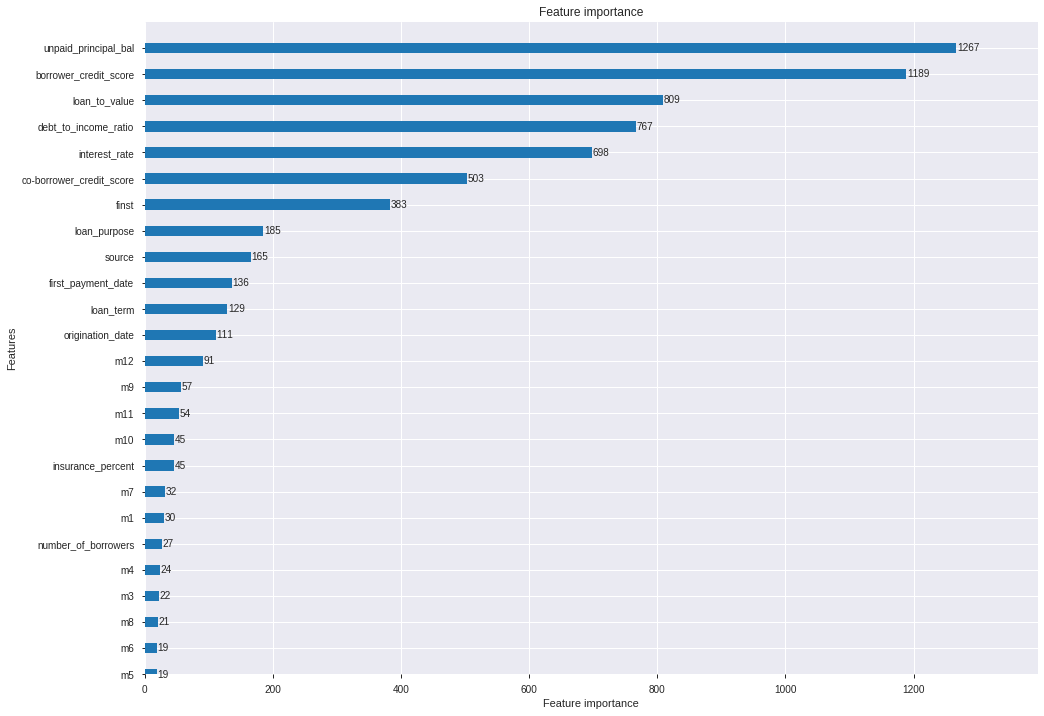

In [15]:
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                        ylim = (0,25), 
                         figsize = (16,12))
plt.show()

# Dimensionality reduction using feature importances

In [16]:
sorted(gbm.feature_importances_,reverse=True)
# borrower credit score was used 263 times in the model.

[1267,
 1189,
 809,
 767,
 698,
 503,
 383,
 185,
 165,
 136,
 129,
 111,
 91,
 57,
 54,
 45,
 45,
 32,
 30,
 27,
 24,
 22,
 21,
 19,
 19,
 13,
 13]

In [17]:
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    print(feature)
    if temp/total >= 0.90:
        print(feature,temp/total) # stop when we 
        break

1267
1189
809
767
698
503
383
185
165
136
129
129 0.9091041727458419


In [18]:
train = train.drop(['m2', 'm4', 'm6', 'm5', 
                    'm8', 'number_of_borrowers'], axis=1)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.15, random_state=20)
X_train.shape

(98649, 21)

In [117]:
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {'n_estimators': [x for x in range(30,60,2)],
              'learning_rate': [0.08, 0.10, 0.15, 0.175], 
              }

gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = [f1_score],
        early_stopping_rounds = 5)
print('Best parameters found by grid search are:', gridsearch.best_params_)

[1]	valid_0's l1: 0.0104706
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103305
[3]	valid_0's l1: 0.010129
[4]	valid_0's l1: 0.00993398
[5]	valid_0's l1: 0.00978511
[6]	valid_0's l1: 0.00963425
[7]	valid_0's l1: 0.00950533
[8]	valid_0's l1: 0.00935348
[9]	valid_0's l1: 0.0092203
[10]	valid_0's l1: 0.00908996
[11]	valid_0's l1: 0.00896598
[12]	valid_0's l1: 0.00885607
[13]	valid_0's l1: 0.00875116
[14]	valid_0's l1: 0.00865035
[15]	valid_0's l1: 0.00828324
[16]	valid_0's l1: 0.00818441
[17]	valid_0's l1: 0.00810727
[18]	valid_0's l1: 0.00802444
[19]	valid_0's l1: 0.00795143
[20]	valid_0's l1: 0.00791025
[21]	valid_0's l1: 0.00785605
[22]	valid_0's l1: 0.00780556
[23]	valid_0's l1: 0.00774463
[24]	valid_0's l1: 0.00769227
[25]	valid_0's l1: 0.00766222
[26]	valid_0's l1: 0.00762608
[27]	valid_0's l1: 0.00758043
[28]	valid_0's l1: 0.00753526
[29]	valid_0's l1: 0.00748538
[30]	valid_0's l1: 0.00744504
Did not meet early stopping. Best iteration is:
[30]	

[1]	valid_0's l1: 0.0104351
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0105271
[3]	valid_0's l1: 0.0101213
[4]	valid_0's l1: 0.00993401
[5]	valid_0's l1: 0.00975513
[6]	valid_0's l1: 0.00961066
[7]	valid_0's l1: 0.00944774
[8]	valid_0's l1: 0.00929736
[9]	valid_0's l1: 0.0091659
[10]	valid_0's l1: 0.0090646
[11]	valid_0's l1: 0.00894342
[12]	valid_0's l1: 0.00884073
[13]	valid_0's l1: 0.00874388
[14]	valid_0's l1: 0.00865587
[15]	valid_0's l1: 0.00858577
[16]	valid_0's l1: 0.00851525
[17]	valid_0's l1: 0.00842454
[18]	valid_0's l1: 0.00837418
[19]	valid_0's l1: 0.00830447
[20]	valid_0's l1: 0.00824562
[21]	valid_0's l1: 0.00818669
[22]	valid_0's l1: 0.00817913
[23]	valid_0's l1: 0.00815726
[24]	valid_0's l1: 0.00809906
[25]	valid_0's l1: 0.00804523
[26]	valid_0's l1: 0.0080231
[27]	valid_0's l1: 0.00797275
[28]	valid_0's l1: 0.00794586
[29]	valid_0's l1: 0.00789895
[30]	valid_0's l1: 0.00785631
[31]	valid_0's l1: 0.00782485
[32]	valid_0's l1: 0.007

[36]	valid_0's l1: 0.00770413
[37]	valid_0's l1: 0.00766886
[38]	valid_0's l1: 0.00765151
Did not meet early stopping. Best iteration is:
[38]	valid_0's l1: 0.00765151
[1]	valid_0's l1: 0.0104706
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103305
[3]	valid_0's l1: 0.010129
[4]	valid_0's l1: 0.00993398
[5]	valid_0's l1: 0.00978511
[6]	valid_0's l1: 0.00963425
[7]	valid_0's l1: 0.00950533
[8]	valid_0's l1: 0.00935348
[9]	valid_0's l1: 0.0092203
[10]	valid_0's l1: 0.00908996
[11]	valid_0's l1: 0.00896598
[12]	valid_0's l1: 0.00885607
[13]	valid_0's l1: 0.00875116
[14]	valid_0's l1: 0.00865035
[15]	valid_0's l1: 0.00828324
[16]	valid_0's l1: 0.00818441
[17]	valid_0's l1: 0.00810727
[18]	valid_0's l1: 0.00802444
[19]	valid_0's l1: 0.00795143
[20]	valid_0's l1: 0.00791025
[21]	valid_0's l1: 0.00785605
[22]	valid_0's l1: 0.00780556
[23]	valid_0's l1: 0.00774463
[24]	valid_0's l1: 0.00769227
[25]	valid_0's l1: 0.00766222
[26]	valid_0's l1: 0.00762608
[27]	

[1]	valid_0's l1: 0.0104706
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103305
[3]	valid_0's l1: 0.010129
[4]	valid_0's l1: 0.00993398
[5]	valid_0's l1: 0.00978511
[6]	valid_0's l1: 0.00963425
[7]	valid_0's l1: 0.00950533
[8]	valid_0's l1: 0.00935348
[9]	valid_0's l1: 0.0092203
[10]	valid_0's l1: 0.00908996
[11]	valid_0's l1: 0.00896598
[12]	valid_0's l1: 0.00885607
[13]	valid_0's l1: 0.00875116
[14]	valid_0's l1: 0.00865035
[15]	valid_0's l1: 0.00828324
[16]	valid_0's l1: 0.00818441
[17]	valid_0's l1: 0.00810727
[18]	valid_0's l1: 0.00802444
[19]	valid_0's l1: 0.00795143
[20]	valid_0's l1: 0.00791025
[21]	valid_0's l1: 0.00785605
[22]	valid_0's l1: 0.00780556
[23]	valid_0's l1: 0.00774463
[24]	valid_0's l1: 0.00769227
[25]	valid_0's l1: 0.00766222
[26]	valid_0's l1: 0.00762608
[27]	valid_0's l1: 0.00758043
[28]	valid_0's l1: 0.00753526
[29]	valid_0's l1: 0.00748538
[30]	valid_0's l1: 0.00744504
[31]	valid_0's l1: 0.00741439
[32]	valid_0's l1: 0.00

[1]	valid_0's l1: 0.0104706
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103305
[3]	valid_0's l1: 0.010129
[4]	valid_0's l1: 0.00993398
[5]	valid_0's l1: 0.00978511
[6]	valid_0's l1: 0.00963425
[7]	valid_0's l1: 0.00950533
[8]	valid_0's l1: 0.00935348
[9]	valid_0's l1: 0.0092203
[10]	valid_0's l1: 0.00908996
[11]	valid_0's l1: 0.00896598
[12]	valid_0's l1: 0.00885607
[13]	valid_0's l1: 0.00875116
[14]	valid_0's l1: 0.00865035
[15]	valid_0's l1: 0.00828324
[16]	valid_0's l1: 0.00818441
[17]	valid_0's l1: 0.00810727
[18]	valid_0's l1: 0.00802444
[19]	valid_0's l1: 0.00795143
[20]	valid_0's l1: 0.00791025
[21]	valid_0's l1: 0.00785605
[22]	valid_0's l1: 0.00780556
[23]	valid_0's l1: 0.00774463
[24]	valid_0's l1: 0.00769227
[25]	valid_0's l1: 0.00766222
[26]	valid_0's l1: 0.00762608
[27]	valid_0's l1: 0.00758043
[28]	valid_0's l1: 0.00753526
[29]	valid_0's l1: 0.00748538
[30]	valid_0's l1: 0.00744504
[31]	valid_0's l1: 0.00741439
[32]	valid_0's l1: 0.00

[14]	valid_0's l1: 0.00865587
[15]	valid_0's l1: 0.00858577
[16]	valid_0's l1: 0.00851525
[17]	valid_0's l1: 0.00842454
[18]	valid_0's l1: 0.00837418
[19]	valid_0's l1: 0.00830447
[20]	valid_0's l1: 0.00824562
[21]	valid_0's l1: 0.00818669
[22]	valid_0's l1: 0.00817913
[23]	valid_0's l1: 0.00815726
[24]	valid_0's l1: 0.00809906
[25]	valid_0's l1: 0.00804523
[26]	valid_0's l1: 0.0080231
[27]	valid_0's l1: 0.00797275
[28]	valid_0's l1: 0.00794586
[29]	valid_0's l1: 0.00789895
[30]	valid_0's l1: 0.00785631
[31]	valid_0's l1: 0.00782485
[32]	valid_0's l1: 0.00778274
[33]	valid_0's l1: 0.00778377
[34]	valid_0's l1: 0.00775868
[35]	valid_0's l1: 0.00773777
[36]	valid_0's l1: 0.00770413
[37]	valid_0's l1: 0.00766886
[38]	valid_0's l1: 0.00765151
[39]	valid_0's l1: 0.0076188
[40]	valid_0's l1: 0.00758718
[41]	valid_0's l1: 0.00755806
[42]	valid_0's l1: 0.00752998
[43]	valid_0's l1: 0.00750785
[44]	valid_0's l1: 0.00747391
[45]	valid_0's l1: 0.00743809
[46]	valid_0's l1: 0.00743292
[47]	valid_0

[9]	valid_0's l1: 0.00923619
[10]	valid_0's l1: 0.00908536
[11]	valid_0's l1: 0.00893374
[12]	valid_0's l1: 0.00888716
[13]	valid_0's l1: 0.00878877
[14]	valid_0's l1: 0.00870142
[15]	valid_0's l1: 0.00863909
[16]	valid_0's l1: 0.00853291
[17]	valid_0's l1: 0.00844494
[18]	valid_0's l1: 0.00837297
[19]	valid_0's l1: 0.0082739
[20]	valid_0's l1: 0.00818386
[21]	valid_0's l1: 0.008103
[22]	valid_0's l1: 0.00801613
[23]	valid_0's l1: 0.00795174
[24]	valid_0's l1: 0.00789418
[25]	valid_0's l1: 0.00783144
[26]	valid_0's l1: 0.00775332
[27]	valid_0's l1: 0.00769711
[28]	valid_0's l1: 0.00762807
[29]	valid_0's l1: 0.00757121
[30]	valid_0's l1: 0.00753194
[31]	valid_0's l1: 0.00750148
[32]	valid_0's l1: 0.0074673
[33]	valid_0's l1: 0.00743295
[34]	valid_0's l1: 0.00742274
[35]	valid_0's l1: 0.00739467
[36]	valid_0's l1: 0.00736113
[37]	valid_0's l1: 0.00749315
[38]	valid_0's l1: 0.0074401
[39]	valid_0's l1: 0.00739137
[40]	valid_0's l1: 0.00734151
[41]	valid_0's l1: 0.00729635
[42]	valid_0's l

[1]	valid_0's l1: 0.0104706
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0103305
[3]	valid_0's l1: 0.010129
[4]	valid_0's l1: 0.00993398
[5]	valid_0's l1: 0.00978511
[6]	valid_0's l1: 0.00963425
[7]	valid_0's l1: 0.00950533
[8]	valid_0's l1: 0.00935348
[9]	valid_0's l1: 0.0092203
[10]	valid_0's l1: 0.00908996
[11]	valid_0's l1: 0.00896598
[12]	valid_0's l1: 0.00885607
[13]	valid_0's l1: 0.00875116
[14]	valid_0's l1: 0.00865035
[15]	valid_0's l1: 0.00828324
[16]	valid_0's l1: 0.00818441
[17]	valid_0's l1: 0.00810727
[18]	valid_0's l1: 0.00802444
[19]	valid_0's l1: 0.00795143
[20]	valid_0's l1: 0.00791025
[21]	valid_0's l1: 0.00785605
[22]	valid_0's l1: 0.00780556
[23]	valid_0's l1: 0.00774463
[24]	valid_0's l1: 0.00769227
[25]	valid_0's l1: 0.00766222
[26]	valid_0's l1: 0.00762608
[27]	valid_0's l1: 0.00758043
[28]	valid_0's l1: 0.00753526
[29]	valid_0's l1: 0.00748538
[30]	valid_0's l1: 0.00744504
[31]	valid_0's l1: 0.00741439
[32]	valid_0's l1: 0.00

[1]	valid_0's l1: 0.0106267
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104611
[3]	valid_0's l1: 0.00983214
[4]	valid_0's l1: 0.00987594
[5]	valid_0's l1: 0.00973066
[6]	valid_0's l1: 0.00967415
[7]	valid_0's l1: 0.00947463
[8]	valid_0's l1: 0.00930447
[9]	valid_0's l1: 0.00916198
[10]	valid_0's l1: 0.00901932
[11]	valid_0's l1: 0.00892479
[12]	valid_0's l1: 0.00890607
[13]	valid_0's l1: 0.00872142
[14]	valid_0's l1: 0.00860686
[15]	valid_0's l1: 0.00849957
[16]	valid_0's l1: 0.00840904
[17]	valid_0's l1: 0.00830663
[18]	valid_0's l1: 0.0082818
[19]	valid_0's l1: 0.00821329
[20]	valid_0's l1: 0.0081451
[21]	valid_0's l1: 0.00809607
[22]	valid_0's l1: 0.00805918
[23]	valid_0's l1: 0.00812617
[24]	valid_0's l1: 0.0079105
[25]	valid_0's l1: 0.00793215
[26]	valid_0's l1: 0.00787752
[27]	valid_0's l1: 0.0078717
[28]	valid_0's l1: 0.00781162
[29]	valid_0's l1: 0.00776337
[30]	valid_0's l1: 0.00771839
[31]	valid_0's l1: 0.00765851
[32]	valid_0's l1: 0.007

[1]	valid_0's l1: 0.0106654
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0110931
[3]	valid_0's l1: 0.0109048
[4]	valid_0's l1: 0.0110786
[5]	valid_0's l1: 0.0108747
[6]	valid_0's l1: 0.0105941
[7]	valid_0's l1: 0.0104546
[8]	valid_0's l1: 0.010324
[9]	valid_0's l1: 0.010215
[10]	valid_0's l1: 0.0100701
[11]	valid_0's l1: 0.0100287
[12]	valid_0's l1: 0.00974581
[13]	valid_0's l1: 0.00898284
[14]	valid_0's l1: 0.0089011
[15]	valid_0's l1: 0.0089604
[16]	valid_0's l1: 0.00888403
[17]	valid_0's l1: 0.00883542
[18]	valid_0's l1: 0.00873144
[19]	valid_0's l1: 0.00862322
[20]	valid_0's l1: 0.00836575
[21]	valid_0's l1: 0.00832904
[22]	valid_0's l1: 0.00827592
[23]	valid_0's l1: 0.00819962
[24]	valid_0's l1: 0.00811411
[25]	valid_0's l1: 0.00806307
[26]	valid_0's l1: 0.00800218
[27]	valid_0's l1: 0.00792484
[28]	valid_0's l1: 0.00801852
[29]	valid_0's l1: 0.00801926
[30]	valid_0's l1: 0.00805409
[31]	valid_0's l1: 0.00802733
[32]	valid_0's l1: 0.00792474
[33

[37]	valid_0's l1: 0.00831905
Early stopping, best iteration is:
[32]	valid_0's l1: 0.00792474
[1]	valid_0's l1: 0.0106267
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104611
[3]	valid_0's l1: 0.00983214
[4]	valid_0's l1: 0.00987594
[5]	valid_0's l1: 0.00973066
[6]	valid_0's l1: 0.00967415
[7]	valid_0's l1: 0.00947463
[8]	valid_0's l1: 0.00930447
[9]	valid_0's l1: 0.00916198
[10]	valid_0's l1: 0.00901932
[11]	valid_0's l1: 0.00892479
[12]	valid_0's l1: 0.00890607
[13]	valid_0's l1: 0.00872142
[14]	valid_0's l1: 0.00860686
[15]	valid_0's l1: 0.00849957
[16]	valid_0's l1: 0.00840904
[17]	valid_0's l1: 0.00830663
[18]	valid_0's l1: 0.0082818
[19]	valid_0's l1: 0.00821329
[20]	valid_0's l1: 0.0081451
[21]	valid_0's l1: 0.00809607
[22]	valid_0's l1: 0.00805918
[23]	valid_0's l1: 0.00812617
[24]	valid_0's l1: 0.0079105
[25]	valid_0's l1: 0.00793215
[26]	valid_0's l1: 0.00787752
[27]	valid_0's l1: 0.0078717
[28]	valid_0's l1: 0.00781162
[29]	valid_0's l1: 

[36]	valid_0's l1: 0.00785208
[37]	valid_0's l1: 0.00796439
[38]	valid_0's l1: 0.0079275
Early stopping, best iteration is:
[33]	valid_0's l1: 0.00756242
[1]	valid_0's l1: 0.0104617
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0105717
[3]	valid_0's l1: 0.00970142
[4]	valid_0's l1: 0.00949737
[5]	valid_0's l1: 0.00927875
[6]	valid_0's l1: 0.00907689
[7]	valid_0's l1: 0.00892435
[8]	valid_0's l1: 0.00873692
[9]	valid_0's l1: 0.00865512
[10]	valid_0's l1: 0.00849408
[11]	valid_0's l1: 0.0083533
[12]	valid_0's l1: 0.00823913
[13]	valid_0's l1: 0.00812071
[14]	valid_0's l1: 0.00829068
[15]	valid_0's l1: 0.00818136
[16]	valid_0's l1: 0.00805748
[17]	valid_0's l1: 0.00794638
[18]	valid_0's l1: 0.00795146
[19]	valid_0's l1: 0.0078735
[20]	valid_0's l1: 0.0077739
[21]	valid_0's l1: 0.00768917
[22]	valid_0's l1: 0.00762351
[23]	valid_0's l1: 0.00765656
[24]	valid_0's l1: 0.00768227
[25]	valid_0's l1: 0.00759378
[26]	valid_0's l1: 0.00747728
[27]	valid_0's l1: 

[14]	valid_0's l1: 0.00829068
[15]	valid_0's l1: 0.00818136
[16]	valid_0's l1: 0.00805748
[17]	valid_0's l1: 0.00794638
[18]	valid_0's l1: 0.00795146
[19]	valid_0's l1: 0.0078735
[20]	valid_0's l1: 0.0077739
[21]	valid_0's l1: 0.00768917
[22]	valid_0's l1: 0.00762351
[23]	valid_0's l1: 0.00765656
[24]	valid_0's l1: 0.00768227
[25]	valid_0's l1: 0.00759378
[26]	valid_0's l1: 0.00747728
[27]	valid_0's l1: 0.00742156
[28]	valid_0's l1: 0.00735684
[29]	valid_0's l1: 0.00733167
[30]	valid_0's l1: 0.00742694
[31]	valid_0's l1: 0.00742279
[32]	valid_0's l1: 0.00740244
[33]	valid_0's l1: 0.00733974
[34]	valid_0's l1: 0.00729811
[35]	valid_0's l1: 0.00725518
[36]	valid_0's l1: 0.00719555
[37]	valid_0's l1: 0.00717565
[38]	valid_0's l1: 0.00715352
[39]	valid_0's l1: 0.00775681
[40]	valid_0's l1: 0.00710781
[41]	valid_0's l1: 0.00714936
[42]	valid_0's l1: 0.00718264
[43]	valid_0's l1: 0.00704784
[44]	valid_0's l1: 0.00750522
[45]	valid_0's l1: 0.00702162
[46]	valid_0's l1: 0.00701527
[47]	valid_0

[44]	valid_0's l1: 0.00750522
[45]	valid_0's l1: 0.00702162
[46]	valid_0's l1: 0.00701527
[47]	valid_0's l1: 0.00700743
[48]	valid_0's l1: 0.00704473
[49]	valid_0's l1: 0.00777493
[50]	valid_0's l1: 0.00791916
[51]	valid_0's l1: 0.00738721
[52]	valid_0's l1: 0.00772693
Early stopping, best iteration is:
[47]	valid_0's l1: 0.00700743
[1]	valid_0's l1: 0.0106654
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0110931
[3]	valid_0's l1: 0.0109048
[4]	valid_0's l1: 0.0110786
[5]	valid_0's l1: 0.0108747
[6]	valid_0's l1: 0.0105941
[7]	valid_0's l1: 0.0104546
[8]	valid_0's l1: 0.010324
[9]	valid_0's l1: 0.010215
[10]	valid_0's l1: 0.0100701
[11]	valid_0's l1: 0.0100287
[12]	valid_0's l1: 0.00974581
[13]	valid_0's l1: 0.00898284
[14]	valid_0's l1: 0.0089011
[15]	valid_0's l1: 0.0089604
[16]	valid_0's l1: 0.00888403
[17]	valid_0's l1: 0.00883542
[18]	valid_0's l1: 0.00873144
[19]	valid_0's l1: 0.00862322
[20]	valid_0's l1: 0.00836575
[21]	valid_0's l1: 0.0083290

[1]	valid_0's l1: 0.0106654
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0110931
[3]	valid_0's l1: 0.0109048
[4]	valid_0's l1: 0.0110786
[5]	valid_0's l1: 0.0108747
[6]	valid_0's l1: 0.0105941
[7]	valid_0's l1: 0.0104546
[8]	valid_0's l1: 0.010324
[9]	valid_0's l1: 0.010215
[10]	valid_0's l1: 0.0100701
[11]	valid_0's l1: 0.0100287
[12]	valid_0's l1: 0.00974581
[13]	valid_0's l1: 0.00898284
[14]	valid_0's l1: 0.0089011
[15]	valid_0's l1: 0.0089604
[16]	valid_0's l1: 0.00888403
[17]	valid_0's l1: 0.00883542
[18]	valid_0's l1: 0.00873144
[19]	valid_0's l1: 0.00862322
[20]	valid_0's l1: 0.00836575
[21]	valid_0's l1: 0.00832904
[22]	valid_0's l1: 0.00827592
[23]	valid_0's l1: 0.00819962
[24]	valid_0's l1: 0.00811411
[25]	valid_0's l1: 0.00806307
[26]	valid_0's l1: 0.00800218
[27]	valid_0's l1: 0.00792484
[28]	valid_0's l1: 0.00801852
[29]	valid_0's l1: 0.00801926
[30]	valid_0's l1: 0.00805409
[31]	valid_0's l1: 0.00802733
[32]	valid_0's l1: 0.00792474
[33

[1]	valid_0's l1: 0.0108554
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108102
[3]	valid_0's l1: 0.0106025
[4]	valid_0's l1: 0.0104429
[5]	valid_0's l1: 0.00989061
[6]	valid_0's l1: 0.00982627
[7]	valid_0's l1: 0.009898
[8]	valid_0's l1: 0.00967433
[9]	valid_0's l1: 0.00957478
[10]	valid_0's l1: 0.00979314
[11]	valid_0's l1: 0.00998959
[12]	valid_0's l1: 0.00966774
[13]	valid_0's l1: 0.00964318
[14]	valid_0's l1: 0.00951366
[15]	valid_0's l1: 0.00942542
[16]	valid_0's l1: 0.00949834
[17]	valid_0's l1: 0.00926073
[18]	valid_0's l1: 0.00902281
[19]	valid_0's l1: 0.00892539
[20]	valid_0's l1: 0.00880587
[21]	valid_0's l1: 0.00885946
[22]	valid_0's l1: 0.0090686
[23]	valid_0's l1: 0.00993146
[24]	valid_0's l1: 0.00911862
[25]	valid_0's l1: 0.00899614
Early stopping, best iteration is:
[20]	valid_0's l1: 0.00880587
[1]	valid_0's l1: 0.0112136
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108263
[3]	valid_0's l1: 0.010

[1]	valid_0's l1: 0.0108554
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108102
[3]	valid_0's l1: 0.0106025
[4]	valid_0's l1: 0.0104429
[5]	valid_0's l1: 0.00989061
[6]	valid_0's l1: 0.00982627
[7]	valid_0's l1: 0.009898
[8]	valid_0's l1: 0.00967433
[9]	valid_0's l1: 0.00957478
[10]	valid_0's l1: 0.00979314
[11]	valid_0's l1: 0.00998959
[12]	valid_0's l1: 0.00966774
[13]	valid_0's l1: 0.00964318
[14]	valid_0's l1: 0.00951366
[15]	valid_0's l1: 0.00942542
[16]	valid_0's l1: 0.00949834
[17]	valid_0's l1: 0.00926073
[18]	valid_0's l1: 0.00902281
[19]	valid_0's l1: 0.00892539
[20]	valid_0's l1: 0.00880587
[21]	valid_0's l1: 0.00885946
[22]	valid_0's l1: 0.0090686
[23]	valid_0's l1: 0.00993146
[24]	valid_0's l1: 0.00911862
[25]	valid_0's l1: 0.00899614
Early stopping, best iteration is:
[20]	valid_0's l1: 0.00880587
[1]	valid_0's l1: 0.0112136
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108263
[3]	valid_0's l1: 0.010

[1]	valid_0's l1: 0.0108554
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108102
[3]	valid_0's l1: 0.0106025
[4]	valid_0's l1: 0.0104429
[5]	valid_0's l1: 0.00989061
[6]	valid_0's l1: 0.00982627
[7]	valid_0's l1: 0.009898
[8]	valid_0's l1: 0.00967433
[9]	valid_0's l1: 0.00957478
[10]	valid_0's l1: 0.00979314
[11]	valid_0's l1: 0.00998959
[12]	valid_0's l1: 0.00966774
[13]	valid_0's l1: 0.00964318
[14]	valid_0's l1: 0.00951366
[15]	valid_0's l1: 0.00942542
[16]	valid_0's l1: 0.00949834
[17]	valid_0's l1: 0.00926073
[18]	valid_0's l1: 0.00902281
[19]	valid_0's l1: 0.00892539
[20]	valid_0's l1: 0.00880587
[21]	valid_0's l1: 0.00885946
[22]	valid_0's l1: 0.0090686
[23]	valid_0's l1: 0.00993146
[24]	valid_0's l1: 0.00911862
[25]	valid_0's l1: 0.00899614
Early stopping, best iteration is:
[20]	valid_0's l1: 0.00880587
[1]	valid_0's l1: 0.0112136
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108263
[3]	valid_0's l1: 0.010

[1]	valid_0's l1: 0.0110059
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104286
[3]	valid_0's l1: 0.0102152
[4]	valid_0's l1: 0.0103518
[5]	valid_0's l1: 0.00959053
[6]	valid_0's l1: 0.00938152
[7]	valid_0's l1: 0.00949863
[8]	valid_0's l1: 0.00923108
[9]	valid_0's l1: 0.00908661
[10]	valid_0's l1: 0.00906166
[11]	valid_0's l1: 0.0089619
[12]	valid_0's l1: 0.00886932
[13]	valid_0's l1: 0.00865783
[14]	valid_0's l1: 0.00869421
[15]	valid_0's l1: 0.00876463
[16]	valid_0's l1: 0.00942451
[17]	valid_0's l1: 0.00872615
[18]	valid_0's l1: 0.00925131
Early stopping, best iteration is:
[13]	valid_0's l1: 0.00865783
[1]	valid_0's l1: 0.011468
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0106908
[3]	valid_0's l1: 0.0115358
[4]	valid_0's l1: 0.0104462
[5]	valid_0's l1: 0.0102595
[6]	valid_0's l1: 0.0100534
[7]	valid_0's l1: 0.00980978
[8]	valid_0's l1: 0.00962699
[9]	valid_0's l1: 0.00952491
[10]	valid_0's l1: 0.00935586
[11

[1]	valid_0's l1: 0.011468
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0106908
[3]	valid_0's l1: 0.0115358
[4]	valid_0's l1: 0.0104462
[5]	valid_0's l1: 0.0102595
[6]	valid_0's l1: 0.0100534
[7]	valid_0's l1: 0.00980978
[8]	valid_0's l1: 0.00962699
[9]	valid_0's l1: 0.00952491
[10]	valid_0's l1: 0.00935586
[11]	valid_0's l1: 0.00987989
[12]	valid_0's l1: 0.0104333
[13]	valid_0's l1: 0.0103154
[14]	valid_0's l1: 0.0101845
[15]	valid_0's l1: 0.0101563
Early stopping, best iteration is:
[10]	valid_0's l1: 0.00935586
[1]	valid_0's l1: 0.0110688
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0108723
[3]	valid_0's l1: 0.0106948
[4]	valid_0's l1: 0.0104462
[5]	valid_0's l1: 0.0100442
[6]	valid_0's l1: 0.00984097
[7]	valid_0's l1: 0.0096244
[8]	valid_0's l1: 0.00959142
[9]	valid_0's l1: 0.00946347
[10]	valid_0's l1: 0.0094636
[11]	valid_0's l1: 0.0101429
[12]	valid_0's l1: 0.00894482
[13]	valid_0's l1: 0.0085809
[14]	valid_

[2]	valid_0's l1: 0.0108723
[3]	valid_0's l1: 0.0106948
[4]	valid_0's l1: 0.0104462
[5]	valid_0's l1: 0.0100442
[6]	valid_0's l1: 0.00984097
[7]	valid_0's l1: 0.0096244
[8]	valid_0's l1: 0.00959142
[9]	valid_0's l1: 0.00946347
[10]	valid_0's l1: 0.0094636
[11]	valid_0's l1: 0.0101429
[12]	valid_0's l1: 0.00894482
[13]	valid_0's l1: 0.0085809
[14]	valid_0's l1: 0.00851444
[15]	valid_0's l1: 0.00832622
[16]	valid_0's l1: 0.00820923
[17]	valid_0's l1: 0.00808126
[18]	valid_0's l1: 0.00832719
[19]	valid_0's l1: 0.0088572
[20]	valid_0's l1: 0.00941141
[21]	valid_0's l1: 0.00907754
[22]	valid_0's l1: 0.0091239
Early stopping, best iteration is:
[17]	valid_0's l1: 0.00808126
[1]	valid_0's l1: 0.0110059
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104286
[3]	valid_0's l1: 0.0102152
[4]	valid_0's l1: 0.0103518
[5]	valid_0's l1: 0.00959053
[6]	valid_0's l1: 0.00938152
[7]	valid_0's l1: 0.00949863
[8]	valid_0's l1: 0.00923108
[9]	valid_0's l1: 0.00908661
[10]	

[1]	valid_0's l1: 0.0110059
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0104286
[3]	valid_0's l1: 0.0102152
[4]	valid_0's l1: 0.0103518
[5]	valid_0's l1: 0.00959053
[6]	valid_0's l1: 0.00938152
[7]	valid_0's l1: 0.00949863
[8]	valid_0's l1: 0.00923108
[9]	valid_0's l1: 0.00908661
[10]	valid_0's l1: 0.00906166
[11]	valid_0's l1: 0.0089619
[12]	valid_0's l1: 0.00886932
[13]	valid_0's l1: 0.00865783
[14]	valid_0's l1: 0.00869421
[15]	valid_0's l1: 0.00876463
[16]	valid_0's l1: 0.00942451
[17]	valid_0's l1: 0.00872615
[18]	valid_0's l1: 0.00925131
Early stopping, best iteration is:
[13]	valid_0's l1: 0.00865783
[1]	valid_0's l1: 0.011468
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0106908
[3]	valid_0's l1: 0.0115358
[4]	valid_0's l1: 0.0104462
[5]	valid_0's l1: 0.0102595
[6]	valid_0's l1: 0.0100534
[7]	valid_0's l1: 0.00980978
[8]	valid_0's l1: 0.00962699
[9]	valid_0's l1: 0.00952491
[10]	valid_0's l1: 0.00935586
[11

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.125, max_depth=-1,
                                      metric='l1', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=20,
                                      n_jobs=-1, num_leaves=38, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.08, 0.1, 0.15, 0.175

Best parameters found by grid search are: {'learning_rate': 0.08, 'n_estimators': 58}


In [120]:
gbm = lgb.LGBMClassifier(learning_rate = 0.08, metric = 'l1', n_estimators = 58)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=[f1_score], early_stopping_rounds=5)

[1]	valid_0's l1: 0.0106171
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0109247
[3]	valid_0's l1: 0.010606
[4]	valid_0's l1: 0.0103369
[5]	valid_0's l1: 0.0101363
[6]	valid_0's l1: 0.00990887
[7]	valid_0's l1: 0.00974611
[8]	valid_0's l1: 0.00960478
[9]	valid_0's l1: 0.00946464
[10]	valid_0's l1: 0.00934248
[11]	valid_0's l1: 0.00923254
[12]	valid_0's l1: 0.00911811
[13]	valid_0's l1: 0.00900995
[14]	valid_0's l1: 0.00891244
[15]	valid_0's l1: 0.00884288
[16]	valid_0's l1: 0.00878884
[17]	valid_0's l1: 0.00871853
[18]	valid_0's l1: 0.00863583
[19]	valid_0's l1: 0.00858215
[20]	valid_0's l1: 0.00851854
[21]	valid_0's l1: 0.00844968
[22]	valid_0's l1: 0.00838683
[23]	valid_0's l1: 0.00833834
[24]	valid_0's l1: 0.00832024
[25]	valid_0's l1: 0.00829123
[26]	valid_0's l1: 0.00823594
[27]	valid_0's l1: 0.00824318
[28]	valid_0's l1: 0.00824772
[29]	valid_0's l1: 0.00819325
[30]	valid_0's l1: 0.00814274
[31]	valid_0's l1: 0.00811376
[32]	valid_0's l1: 0.008

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08, max_depth=-1,
               metric='l1', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=58, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [19]:
test = test.drop(['m2', 'm4', 'm6', 'm5' ,
                    'm8', 'number_of_borrowers'], axis=1)

In [28]:
gbm.fit(train, y)
pred=gbm.predict(test)
pd.DataFrame({'loan_id':key1, 'm13': pred}).to_csv('lgb40.csv', index=False)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08, max_depth=-1,
               metric='l1', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=48, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [24]:
active_imports()

import pandas as pd
import pandas_profiling


['import pandas as pd', 'import pandas_profiling']